## Imports

In [1]:
import os
import tempfile

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import tensorflow_recommenders as tfrs

from typing import Dict, Text

plt.style.use('seaborn-v0_8-whitegrid')

2023-12-03 02:17:49.815489: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-03 02:17:49.846863: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-03 02:17:49.846908: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-03 02:17:49.847616: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-03 02:17:49.853434: I tensorflow/core/platform/cpu_feature_guar

## Loading data

Load requried features

In [2]:
ratings = tfds.load("movielens/100k-ratings", split="train")
movies = tfds.load("movielens/100k-movies", split="train")

ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"],
    "user_gender": int(x["user_gender"]),
    "user_zip_code": x["user_zip_code"],
    "user_occupation_text": x["user_occupation_text"],
    "bucketized_user_age": int(x["bucketized_user_age"]),
    "timestamp": x["timestamp"],
})
movies = movies.map(lambda x: x["movie_title"])

2023-12-03 02:17:53.802528: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-03 02:17:53.956496: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-03 02:17:53.956598: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-03 02:17:53.959561: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-03 02:17:53.959625: I external/local_xla/xla/stream_executor

Some housekeeping

In [3]:
timestamps = np.concatenate(list(ratings.map(lambda x: x["timestamp"]).batch(100)))

max_timestamp = timestamps.max()
min_timestamp = timestamps.min()

timestamp_buckets = np.linspace(min_timestamp, max_timestamp, num=1000,)

unique_movie_titles = np.unique(np.concatenate(list(movies.batch(1000))))
unique_user_ids = np.unique(np.concatenate(list(ratings.batch(1_000).map(
    lambda x: x["user_id"]))))
unique_occupations = np.unique(np.concatenate(list(ratings.batch(1_000).map(
    lambda x: x["user_occupation_text"]))))
unique_zipcodes = np.unique(np.concatenate(list(ratings.batch(1_000).map(
    lambda x: x["user_zip_code"]))))
unique_genders = np.unique(np.concatenate(list(ratings.batch(1_000).map(
    lambda x: x["user_gender"]))))
unique_ages = np.unique(np.concatenate(list(ratings.batch(1_000).map(
    lambda x: x["bucketized_user_age"]))))

Splitting the data

In [4]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

cached_train = train.shuffle(100_000).batch(2048)
cached_test = test.batch(4096).cache()

## Model definition
### Query model

In [5]:
class UserModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
        self.user_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=unique_user_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_user_ids) + 1, int(len(unique_user_ids) ** 0.25)),
        ])
        self.timestamp_embedding = tf.keras.Sequential([
            tf.keras.layers.Discretization(timestamp_buckets.tolist()),
            tf.keras.layers.Embedding(len(timestamp_buckets) + 1, int(len(timestamp_buckets) ** 0.25)),
        ])
        self.normalized_timestamp = tf.keras.layers.Normalization(axis=None)
        self.normalized_timestamp.adapt(timestamps)
        
        self.occupation_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=unique_occupations, mask_token=None),
            tf.keras.layers.Embedding(len(unique_occupations) + 1, int(len(unique_occupations) ** 0.25)),
        ])
        self.zipcode_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=unique_zipcodes, mask_token=None),
            tf.keras.layers.Embedding(len(unique_zipcodes) + 1, int(len(unique_zipcodes) ** 0.25)),
        ])
        self.gender_embedding = tf.keras.Sequential([
            tf.keras.layers.IntegerLookup(vocabulary=unique_genders, mask_token=None),
            tf.keras.layers.Embedding(len(unique_genders) + 1, int(len(unique_genders) ** 0.25)),
        ])
        self.age_embedding = tf.keras.Sequential([
            tf.keras.layers.IntegerLookup(vocabulary=unique_ages, mask_token=None),
            tf.keras.layers.Embedding(len(unique_ages) + 1, int(len(unique_ages) ** 0.25)),
        ])
    
    def call(self, inputs):
        # Take the input dictionary, pass it through each input layer,
        # and concatenate the result.
        return tf.concat([
            self.user_embedding(inputs["user_id"]),
            self.timestamp_embedding(inputs["timestamp"]),
            tf.reshape(self.normalized_timestamp(inputs["timestamp"]), (-1, 1)),
            self.occupation_embedding(inputs["user_occupation_text"]),
            self.zipcode_embedding(inputs["user_zip_code"]),
            self.gender_embedding(inputs["user_gender"]),
            self.age_embedding(inputs["bucketized_user_age"]),
        ], axis=1)

In [6]:
class QueryModel(tf.keras.Model):
    """Model for encoding user queries."""
    
    def __init__(self, layer_sizes, projection_dim=None):
        """Model for encoding user queries.
        
        Args:
          layer_sizes:
            A list of integers where the i-th entry represents the number of units
            the i-th layer contains.
        """
        super().__init__()
        
        # We first use the user model for generating embeddings.
        self.embedding_model = UserModel()

        # Cross & Dense layer
        self._cross_layer = tfrs.layers.dcn.Cross(
            projection_dim=projection_dim,
            kernel_initializer="glorot_uniform")
        
        # Then construct the layers.
        self.dense_layers = tf.keras.Sequential()
        
        # Use the ReLU activation for all but the last layer.
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))
        
        # No activation for the last layer.
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size))
    
    def call(self, inputs):
        feature_embedding = self.embedding_model(inputs)
        feature_embedding = self._cross_layer(feature_embedding)
        return self.dense_layers(feature_embedding)

### Candidate model

In [7]:
class MovieModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
        max_tokens = 10_000
        
        self.title_embedding = tf.keras.Sequential([
          tf.keras.layers.StringLookup(
              vocabulary=unique_movie_titles,mask_token=None),
          tf.keras.layers.Embedding(len(unique_movie_titles) + 1, 32)
        ])
        
        self.title_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_tokens)
        
        self.title_text_embedding = tf.keras.Sequential([
          self.title_vectorizer,
          tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
          tf.keras.layers.GlobalAveragePooling1D(),
        ])
        
        self.title_vectorizer.adapt(movies)

    def call(self, titles):
        return tf.concat([
            self.title_embedding(titles),
            self.title_text_embedding(titles),
        ], axis=1)

In [8]:
class CandidateModel(tf.keras.Model):
    """Model for encoding movies."""
    
    def __init__(self, layer_sizes, projection_dim=None):
        """Model for encoding movies.
        
        Args:
          layer_sizes:
            A list of integers where the i-th entry represents the number of units
            the i-th layer contains.
        """
        super().__init__()
        
        self.embedding_model = MovieModel()

        # Cross & Dense layer
        self._cross_layer = tfrs.layers.dcn.Cross(
            projection_dim=projection_dim,
            kernel_initializer="glorot_uniform")
        
        # Then construct the layers.
        self.dense_layers = tf.keras.Sequential()
        
        # Use the ReLU activation for all but the last layer.
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))
        
        # No activation for the last layer.
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size))
    
    def call(self, inputs):
        feature_embedding = self.embedding_model(inputs)
        feature_embedding = self._cross_layer(feature_embedding)
        return self.dense_layers(feature_embedding)

### Combined model

In [9]:
class MovielensModel(tfrs.models.Model):
    def __init__(self,
                 rating_weight: float,
                 query_layer_sizes,
                 candidate_layer_sizes,
                 projection_dim=None):
        assert query_layer_sizes[-1] == candidate_layer_sizes[-1], f'query and candidate embeddings of different sizes: {query_layer_sizes[-1]} and {candidate_layer_sizes[-1]}'
        
        super().__init__()
        self.query_model = QueryModel(query_layer_sizes, projection_dim=projection_dim)
        self.candidate_model = CandidateModel(candidate_layer_sizes, projection_dim=projection_dim)
        # A small model to take in user and movie embeddings and predict ratings.
        # We can make this as complicated as we want as long as we output a scalar
        # as our prediction.
        self.rating_model = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(1),
        ])

        # The tasks.
        self.rating_task = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()],
        )
        self.retrieval_task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
            candidates=movies.batch(128).map(self.candidate_model),
            ),
        )

        # The loss weights.
        self.rating_weight = rating_weight
        self.retrieval_weight = 1 - rating_weight

    def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
        query_embeddings = self.query_model({
            "user_id": features["user_id"],
            "user_gender": features["user_gender"],
            "user_zip_code": features["user_zip_code"],
            "user_occupation_text": features["user_occupation_text"],
            "bucketized_user_age": features["bucketized_user_age"],
            "timestamp": features["timestamp"],
        })
        candidate_embeddings = self.candidate_model(features["movie_title"])

        x = tf.concat([query_embeddings, candidate_embeddings], axis=1)
    
        return (
            query_embeddings,
            candidate_embeddings,
            # We apply the multi-layered rating model to a concatentation of
            # user and movie embeddings.
            self.rating_model(x),
        )
    
    def compute_loss(self, features, training=False):
        ratings = features.pop("user_rating")

        query_embeddings, candidate_embeddings, rating_predictions = self(features)
    
        # We compute the loss for each task.
        rating_loss = self.rating_task(
            labels=ratings,
            predictions=rating_predictions,
        )
        retrieval_loss = self.retrieval_task(query_embeddings, candidate_embeddings)
    
        # And combine them using the loss weights.
        return (self.rating_weight * rating_loss + self.retrieval_weight * retrieval_loss)

## Training

In [10]:
LR = 0.1
EPOCHS = 300
MODEL_NAME = 'DNN-7-96_32-64_32-emb_0.25-cross_emb'

class CustomModelCheckpoint(tf.keras.callbacks.Callback):
    """
    Saves checkpoint on each validation.
    """
    
    def __init__(self, save_dir):
        super().__init__()
        self.save_dir = save_dir
    
    def on_epoch_end(self, epoch, logs=None):
        loss = logs.get('val_loss')
        acc100 = logs.get('val_factorized_top_k/top_100_categorical_accuracy')
        rmse = logs.get('val_root_mean_squared_error')
        if loss is not None:
            cp_name = f'cp-{epoch:03d}_loss-{round(loss)}_acc100-{acc100:.4f}_rmse-{rmse:.4f}.ckpt'
            self.model.save_weights(f'../models/{self.save_dir}/{cp_name}')
            print(f'\nSaved checkpoint to {cp_name}')

cp_callback = CustomModelCheckpoint(MODEL_NAME)

In [11]:
model = MovielensModel(0.5, [96, 32], [64, 32])
model.compile(optimizer=tf.keras.optimizers.Adagrad(LR))

history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=EPOCHS, 
    callbacks=[cp_callback],
    verbose=True)

accuracy = history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
rmse = history.history["val_root_mean_squared_error"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")
print(f"RMSE: {rmse:.2f}.")

Epoch 1/300


2023-12-03 02:18:34.003417: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f852c0b97f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-03 02:18:34.003463: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-12-03 02:18:34.007566: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-03 02:18:34.793235: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1701559114.840334  992025 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40/40 [==============================] - 25s 337ms/step - root_mean_squared_error: 1.6763 - factorized_top_k/top_1_categorical_accuracy: 0.0562 - factorized_top_k/top_5_categorical_accuracy: 0.0785 - factorized_top_k/top_10_categorical_accuracy: 0.0895 - factorized_top_k/top_50_categorical_accuracy: 0.1292 - factorized_top_k/top_100_categorical_accuracy: 0.1643 - loss: 7387.6451 - regularization_loss: 0.0000e+00 - total_loss: 7387.6451
Epoch 2/300
40/40 [==============================] - 12s 224ms/step - root_mean_squared_error: 1.1704 - factorized_top_k/top_1_categorical_accuracy: 0.0324 - factorized_top_k/top_5_categorical_accuracy: 0.0516 - factorized_top_k/top_10_categorical_accuracy: 0.0654 - factorized_top_k/top_50_categorical_accuracy: 0.1340 - factorized_top_k/top_100_categorical_accuracy: 0.1946 - loss: 7165.2751 - regularization_loss: 0.0000e+00 - total_loss: 7165.2751
Epoch 3/300
40/40 [==============================] - 12s 205ms/step - root_mean_squared_error: 1.1547 - fact

### Plot

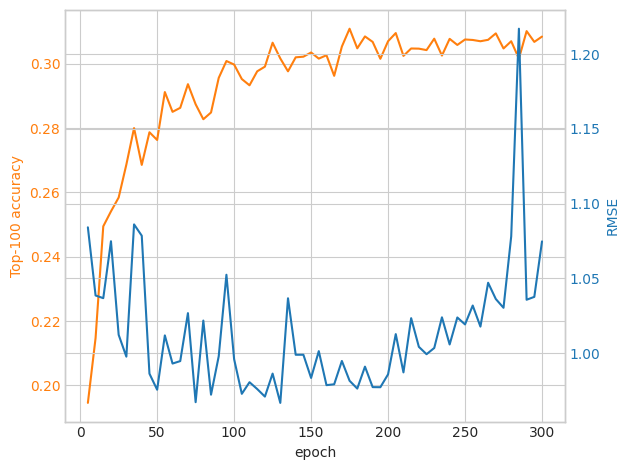

In [12]:
num_validation_runs = len(history.history["val_factorized_top_k/top_100_categorical_accuracy"])
epochs = [(x + 1)* 5 for x in range(num_validation_runs)]
acc = history.history["val_factorized_top_k/top_100_categorical_accuracy"]
rmse = history.history["val_root_mean_squared_error"]

fig, ax1 = plt.subplots()

color = 'tab:orange'
ax1.set_xlabel('epoch')
ax1.set_ylabel('Top-100 accuracy', color=color)
ax1.plot(epochs, acc, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('RMSE', color=color)  # we already handled the x-label with ax1
ax2.plot(epochs, rmse, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig(f'../models/{MODEL_NAME}.png')
plt.show()